In [2]:
import os
import numpy as np

import keras
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D


In [3]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
batch_size = 256
num_classes = 10
epochs = 200
data_augmentation = True

In [4]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 10)
y_test shape: (10000, 10)
50000 train samples
10000 test samples


In [5]:
model = Sequential()
model.add(Conv2D(filters = 96, kernel_size = (11, 11), strides = (4, 4), padding = 'valid', input_shape = x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), padding = "same")) # stride 2 -> 1

model.add(Conv2D(filters = 256, kernel_size = (5, 5), strides = (1, 1), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), padding = "same")) # stride 2 -> 1

model.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (3, 3), strides = (1, 1), padding = "same")) # stride 2 -> 1
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 6, 96)          34944     
_________________________________________________________________
activation (Activation)      (None, 6, 6, 96)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 256)         614656    
_________________________________________________________________
activation_1 (Activation)    (None, 6, 6, 256)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv

In [6]:
model.compile(loss='categorical_crossentropy',
	optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=1e-8),
	metrics=['accuracy'])
model.load_weights('saved_models/A_Model_Weights.h5')

In [7]:
model3_1 = Sequential()
model3_1.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1, 1), padding = 'same', input_shape = x_train.shape[1:]))
model3_1.add(Activation('relu'))
model3_1.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model3_1.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model3_1.add(Activation('relu'))
model3_1.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model3_1.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model3_1.add(Activation('relu'))
model3_1.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model3_1.add(Flatten())
model3_1.add(Dense(500))
model3_1.add(Activation('relu'))
model3_1.add(Dense(num_classes))
model3_1.add(Activation('softmax'))
model3_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 31, 31, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 128)       73856     
__________

In [8]:
def softmax(a) :
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a    
    return y

In [9]:
# Generate soft targets
from tensorflow.keras.layers import Activation, Lambda, concatenate
from tensorflow.keras.models import Model
temperature = 1.0
student_model1 = model
soft_model = Model(inputs = student_model1.layers[0].input, outputs = student_model1.layers[-2].output)
logits = soft_model.predict(x_train)
logits_T = logits / temperature
y_train_soft = np.array([softmax(logit) for logit in logits_T])

In [10]:
# Knowledge_Distillation_Loss
from keras.losses import categorical_crossentropy
from keras import backend as K
def knowledge_distillation_loss(y_true, y_pred, lambda_const):
    y_true, logits = y_true[:, :num_classes], y_true[:, num_classes:]
    y_soft = K.softmax(logits / temperature)
    y_pred, y_pred_soft = y_pred[:, :num_classes], y_pred[:, num_classes:]
    return lambda_const * categorical_crossentropy(y_true, y_pred) + (1-lambda_const) * categorical_crossentropy(y_soft, y_pred_soft)

In [11]:
model3_1.compile(loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, lambda_const = 0),
               optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=1e-8), 
               metrics=['accuracy'])

In [12]:
datagen = ImageDataGenerator(
	width_shift_range=0.1,
	height_shift_range=0.1,
	horizontal_flip=True,  # randomly flip images
	vertical_flip=True)  # randomly flip images
datagen.fit(x_train)

In [13]:
# Fit
hist3_1 = model3_1.fit_generator(datagen.flow(x_train, y_train,
	batch_size=batch_size),
	epochs=epochs,
	validation_data=(x_test, y_test),
	workers=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
196/196 [==============================] - 30s 152ms/step - loss: 0.0000e+00 - acc: 0.1019 - val_loss: 0.0000e+00 - val_acc: 0.1035
Epoch 2/200
196/196 [==============================] - 29s 149ms/step - loss: 0.0000e+00 - acc: 0.1013 - val_loss: 0.0000e+00 - val_acc: 0.1035
Epoch 3/200
196/196 [==============================] - 31s 156ms/step - loss: 0.0000e+00 - acc: 0.1036 - val_loss: 0.0000e+00 - val_acc: 0.1035
Epoch 4/200
196/196 [==============================] - 32s 165ms/step - loss: 0.0000e+00 - acc: 0.1030 - val_loss: 0.0000e+00 - val_acc: 0.1035
Epoch 5/200
196/196 [==============================] - 32s 166ms/step - loss: 0.0000e+00 - acc: 0.1016 - val_loss: 0.0000e+00 - val_acc: 0.1035
Epoch 6/200
196/196 [==============================] - 32s 162ms/step - loss: 0.0000e+00 - acc: 0.1021 - val_loss: 0.0000e+00 - val_acc: 0.1035
Epoch 7/200
196/196 [==============================] - 31s 160ms/step - loss: 0.0000e+00

In [14]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, 'C_Model1_Weights.h5')
model3_1.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Justin\Desktop\Assignment1\saved_models\C_Model1_Weights.h5 


In [15]:
# Score trained model.
train_scores = model3_1.evaluate(x_train, y_train, verbose=1)
print('Train loss:', train_scores[0])
print('Train accuracy:', train_scores[1])
test_scores = model3_1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

50000/50000 [==============================] - 7s 146us/sample - loss: 0.0000e+00 - acc: 0.1085
Train loss: 0.0
Train accuracy: 0.10848
10000/10000 [==============================] - 1s 146us/sample - loss: 0.0000e+00 - acc: 0.1035
Test loss: 0.0
Test accuracy: 0.1035


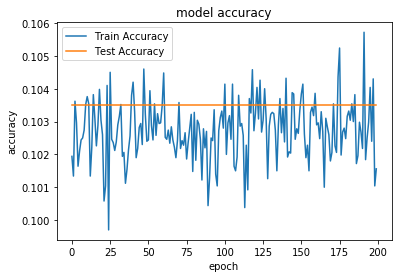

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist3_1.history['acc'])
plt.plot(hist3_1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.show()

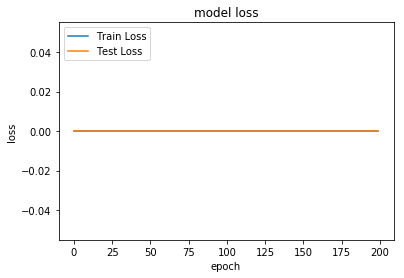

In [25]:
## summarize history for loss
plt.plot(hist3_1.history['loss'])
plt.plot(hist3_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='upper left')
plt.show()

In [18]:
model3_2 = Sequential()
model3_2.add(Conv2D(filters = 32, kernel_size = (5, 5), strides = (1, 1), padding = 'same', input_shape = x_train.shape[1:]))
model3_2.add(Activation('relu'))
model3_2.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model3_2.add(Conv2D(filters = 32, kernel_size = (1, 1), strides = (1, 1), padding = 'same'))
model3_2.add(Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model3_2.add(Conv2D(filters = 64, kernel_size = (1, 1), strides = (1, 1), padding = 'same'))
model3_2.add(Activation('relu'))
model3_2.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model3_2.add(Conv2D(filters = 64, kernel_size = (1, 1), strides = (1, 1), padding = 'same'))
model3_2.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
model3_2.add(Conv2D(filters = 128, kernel_size = (1, 1), strides = (1, 1), padding = 'same'))
model3_2.add(Activation('relu'))
model3_2.add(MaxPooling2D(pool_size = (2, 2), strides = (1, 1), padding = "valid"))

model3_2.add(Flatten())
model3_2.add(Dense(500))
model3_2.add(Activation('relu'))
model3_2.add(Dense(num_classes))
model3_2.add(Activation('softmax'))

model3_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 31, 31, 32)        1056      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 31, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 64)        2112      
_________________________________________________________________
activation_14 (Activation)   (None, 31, 31, 64)        0         
__________

In [19]:
temperature = 1
logits_T2 = logits / temperature
y_train_soft2 = np.array([softmax(logit) for logit in logits_T2])

model3_2.compile(loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, lambda_const = 0),
               optimizer=tf.keras.optimizers.Adam(lr=0.0001, decay=1e-8), 
               metrics=['accuracy'])

# Fit
hist3_2 = model3_2.fit_generator(datagen.flow(x_train, y_train,
	batch_size=batch_size),
	epochs=epochs,
	validation_data=(x_test, y_test),
	workers=0)

Epoch 1/200
196/196 [==============================] - 31s 157ms/step - loss: 0.0000e+00 - acc: 0.0978 - val_loss: 0.0000e+00 - val_acc: 0.0746
Epoch 2/200
196/196 [==============================] - 29s 148ms/step - loss: 0.0000e+00 - acc: 0.0966 - val_loss: 0.0000e+00 - val_acc: 0.0746
Epoch 3/200
196/196 [==============================] - 29s 148ms/step - loss: 0.0000e+00 - acc: 0.1001 - val_loss: 0.0000e+00 - val_acc: 0.0746
Epoch 4/200
196/196 [==============================] - 29s 150ms/step - loss: 0.0000e+00 - acc: 0.0987 - val_loss: 0.0000e+00 - val_acc: 0.0746
Epoch 5/200
196/196 [==============================] - 29s 150ms/step - loss: 0.0000e+00 - acc: 0.0988 - val_loss: 0.0000e+00 - val_acc: 0.0746
Epoch 6/200
196/196 [==============================] - 29s 149ms/step - loss: 0.0000e+00 - acc: 0.0979 - val_loss: 0.0000e+00 - val_acc: 0.0746
Epoch 7/200
196/196 [==============================] - 29s 149ms/step - loss: 0.0000e+00 - acc: 0.0992 - val_loss: 0.0000e+00 - val_acc:

In [20]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, 'C_Model2_Weights.h5')
model3_2.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Justin\Desktop\Assignment1\saved_models\C_Model2_Weights.h5 


In [21]:
# Score trained model.
train_scores2 = model3_2.evaluate(x_train, y_train, verbose=1)
print('Train loss:', train_scores2[0])
print('Train accuracy:', train_scores2[1])
test_scores2 = model3_2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', test_scores2[0])
print('Test accuracy:', test_scores2[1])

50000/50000 [==============================] - 8s 163us/sample - loss: 0.0000e+00 - acc: 0.0730
Train loss: 0.0
Train accuracy: 0.07296
10000/10000 [==============================] - 2s 165us/sample - loss: 0.0000e+00 - acc: 0.0746
Test loss: 0.0
Test accuracy: 0.0746


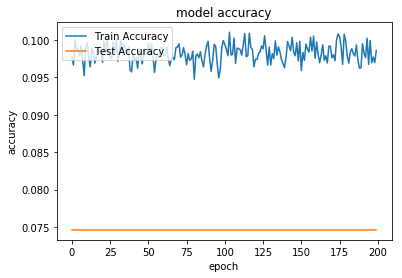

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist3_2.history['acc'])
plt.plot(hist3_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist3_2.history['loss'])
plt.plot(hist3_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='upper left')
plt.show()